In [1]:
import torch
import numpy as np

In [2]:
my_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Etude 1
Let $u$ be a vector of $2D$ points. We need to get a matrix $A$ whose element $(i,j)$ depends on euclidean distance between $u_i$ and $u_j$.

$$u \in \mathbb{R}^{N \times 2}$$
$$A \in \mathbb{R}^{N \times N}, \ A_{ij} = f(\|u_i - u_j\|) $$

Particularly, let's take $f(x) = exp(-\frac{x}{4})$.

### Auxiliary stuff for performance measurement

In [3]:
import time
import matplotlib.pyplot as plt
%matplotlib inline


def bench(func, n_range, repeat=3, device=None, warmup=0):
    """
    Run 'func' with vector sizes in 'n_range'.
    For each vector size average time of 'repeat' runs.
    """
    if warmup:
        for i in range(warmup):
            size = np.random.choice(n_range)
            func(torch.randn(size, 2, device=device))
    t = []
    for n in n_range:
        t0 = []
        for i in range(repeat):
            u = torch.randn(n, 2, device=device)
            start = time.time()
            func(u)
            end = time.time()
            t0.append(end-start)
        t.append(sum(t0)/len(t0))
    return t


def print_interval(ts):
    """
    Print (mean ± std. dev.) interval 
    for the input set of execution times.
    """
    m, dev = np.mean(ts), np.std(ts)
    unit, factor = 's', 1
    if m < 1e-3:
        unit, factor = 'µs', 10**6
    elif m < 1:
        unit, factor = 'ms', 10**3
    m *= factor
    dev *= factor
    print(f"{m:.2f} ± {dev:.2f} {unit} per run (mean ± std. dev. of {len(ts)} runs)")

### Naive approach

In [4]:
def naive(u):
    N = u.shape[0]
    result = torch.zeros(N, N)
    for i in range(N):
        for j in range(N):
            result[i,j] = torch.exp(-0.25 * torch.dist(u[i], u[j]))
    return result

### Vectorized approaches

In [5]:
def fully_vectorized(u):
    u_ = u.reshape(1, *u.shape) # add one dimension for transposing
    A_ = u_.permute((1, 0, 2)) - u_ # row - column: broadcasting subtraction
    return A_.pow_(2).sum(dim=2).sqrt_().mul_(-0.25).exp_()

In [6]:
def one_dim_vectorized(u):
    N = u.shape[0]
    result = torch.zeros(N, N)
    for i in range(N):
        du = u[i] - u
        result[i,:] = du.pow_(2).sum(dim=1).sqrt_().mul_(-0.25).exp_()
    return result

### Comparison

#### fully vectorized vs. naive

In [7]:
N = 10**3
u = torch.randn(N, 2)

In [8]:
%%time
A = naive(u)

CPU times: user 12.1 s, sys: 392 ms, total: 12.5 s
Wall time: 12.5 s


In [9]:
%%time
B = fully_vectorized(u)

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 36.9 ms


In [10]:
assert torch.equal(A, B)

#### 1-dim vectorized vs. fully vectorized

In [11]:
N = 10**4
u = torch.randn(N, 2)

In [12]:
%%timeit
A = fully_vectorized(u)

2.34 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
B = one_dim_vectorized(u)

2.97 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
assert torch.equal(A, B)

In [15]:
ns = list(range(10**3, 6*10**3, 10**3))
t_fv = bench(func=fully_vectorized, n_range=ns)
t_1dv = bench(func=one_dim_vectorized, n_range=ns)

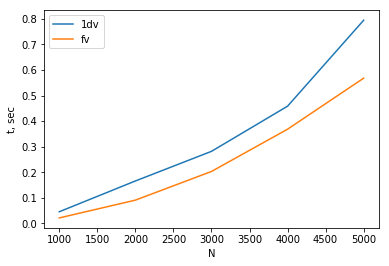

In [16]:
plt.plot(ns, t_1dv, label='1dv')
plt.plot(ns, t_fv, label='fv')
plt.ylabel('t, sec')
plt.xlabel('N')
plt.legend()

### cpu vs. gpu
_Note_: don't use `timeit` for GPU because it disables gc and causes memory error

In [17]:
N = 10**4
ns = [N] * 20

#### Fully vectorized on CPU

In [18]:
ts = bench(fully_vectorized, n_range=ns, repeat=1, warmup=3)
print_interval(ts)

2.37 ± 0.23 s per run (mean ± std. dev. of 20 runs)


#### 1-dim vectorized on GPU

In [19]:
ts = bench(one_dim_vectorized, n_range=ns, repeat=1, device=my_device, warmup=3)
print_interval(ts)

1.49 ± 0.11 s per run (mean ± std. dev. of 20 runs)


#### Fully vectorized on GPU

In [20]:
ts = bench(fully_vectorized, n_range=ns, repeat=1, device=my_device, warmup=3)
print_interval(ts)

99.11 ± 3.32 µs per run (mean ± std. dev. of 20 runs)
